In [155]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc

Общие данные для количества вхождений

In [156]:
list_files = listdir('messages')
words = []
words_count = dict()
files = []
for file in list_files:
    text = open('messages/' + file, 'r').read()
    head, main = text.split('\n\n')
    head = head.split()[1:]
    main = main.split()
    head = list(map(int, head))
    main = list(map(int, main))
    for word in head + main:
        words.append(word)
    head_words = [word for word in head]
    main_words = [word for word in main]
    files.append((head_words, main_words, file))
x = 4

In [157]:
def get_class_file(file_name):
    if 'spmsg' in file_name:
        return 1
    return 0
train_len = int(len(list_files) * 0.8)
y = list([get_class_file(file_name) for file_name in list_files])
train_y = y[:train_len]
test_y = y[train_len:]

In [158]:
from numpy import float64

wrapped_all_words = [[word] for word in words]
data = []
encoder = OneHotEncoder().fit(wrapped_all_words)
for file in files:
    head, main, name_file = file
    text = head + main
    wrapped_text = [[word] for word in text]
    if len(wrapped_text) == 0:
        data.append(csr_matrix((1, len(encoder.categories_[0])), dtype=float64))
        continue
    matrix = encoder.transform(wrapped_text)
    data.append(matrix.sum(axis=0))


In [159]:
train_len = int(len(data) * 0.8)
train = np.asarray(np.concatenate(data[:train_len]))
test = np.asarray(np.concatenate(data[train_len:]))


In [160]:
model = MultinomialNB()
model.fit(train, y[:train_len])

MultinomialNB()

In [161]:
test_score = model.predict_proba(test)


In [162]:
def classify_file(file_name):
    if 'spmsg' in file_name:
        return 1
    if 'legit' in file_name:
        return 0
target = list(map(classify_file, list_files))
train_target = target[:train_len]
test_target = target[train_len:]

In [163]:
fpr, tpr, _ = roc_curve(y[train_len:], test_score[:, 1])
roc_auc = auc(fpr, tpr)

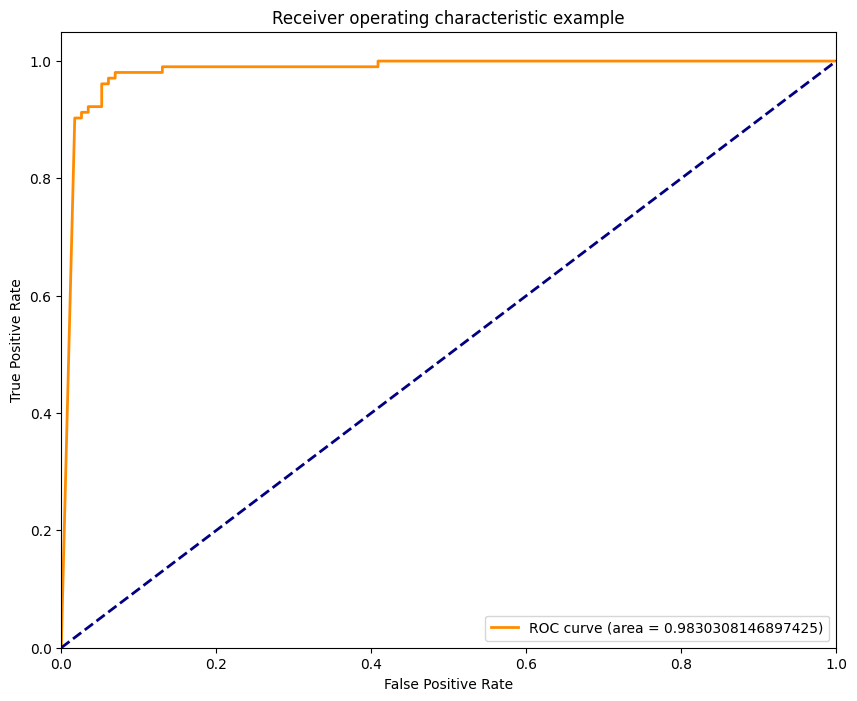

In [164]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = " + str(roc_auc) + ")"
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [165]:
def contains(text_words):
    if len(text_words) == 0:
        return csr_matrix((1, len(encoder.categories_[0])), dtype=float64)
    wrapped_words = [[next_word] for next_word in text_words]
    matrix1 = encoder.transform(wrapped_words)
    return matrix1.max(axis=0)

data = []
for file in files:
    head, main, name_file = file
    data.append(hstack([contains(head), contains(main)]))

In [166]:
train = vstack(data[:train_len])
test = vstack(data[train_len:])

In [167]:
model = MultinomialNB()
model.fit(train, y[:train_len])

MultinomialNB()

In [168]:
y_predicted = model.predict_proba(test)

In [169]:
fpr, tpr, _ = roc_curve(y[train_len:], y_predicted[:, 1])
roc_auc = auc(fpr, tpr)

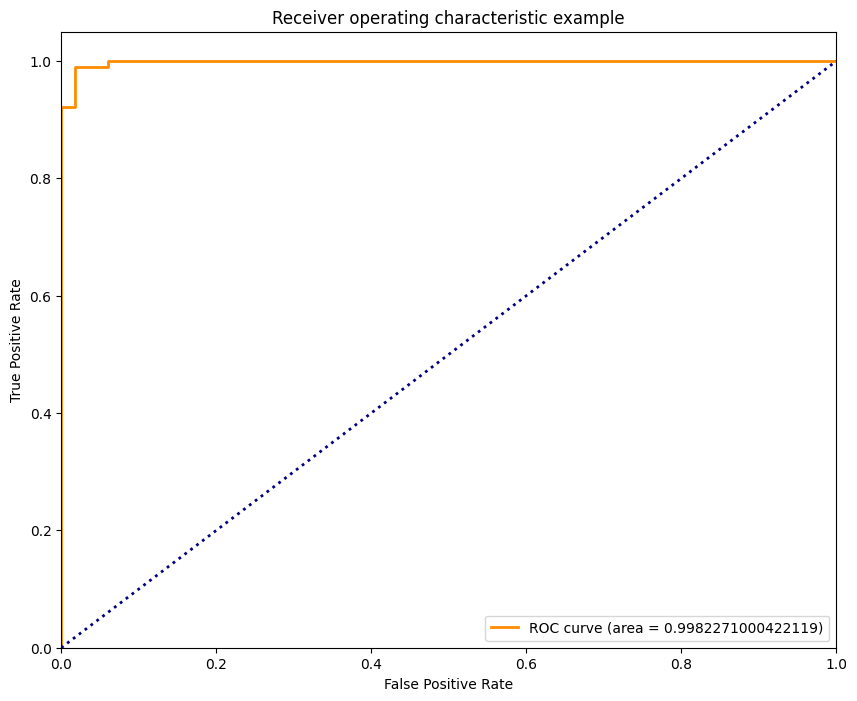

In [170]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = " + str(roc_auc) + ")",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle=":")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [171]:
model = MultinomialNB(class_prior=[1 - 1e-110, 1e-110])
model = model.fit(train, train_target)

In [172]:
_test_target = np.array(test_target)
prediction = model.predict(test)
legit_prediction = prediction[_test_target == 0]
print(f"Count of okay messages classified as spam: {np.sum(legit_prediction)}")

Count of okay messages classified as spam: 0


In [173]:
def accuracy(testy, predy):
    numerator = np.sum(testy == predy)
    return numerator / len(testy)


def prior_accuracy(prior):
    _model = MultinomialNB(class_prior=[1-prior, prior])
    _model.fit(train, train_target)
    log_prob = _model.predict_log_proba(test)
    probs = log_prob[:, 1]
    pred = (probs >= np.log(0.5)).astype('int')
    return accuracy(test_target, pred)

In [174]:
accur = np.vectorize(prior_accuracy)
priors = np.arange(0.01, 1, 0.01)
accuracies = accur(priors)

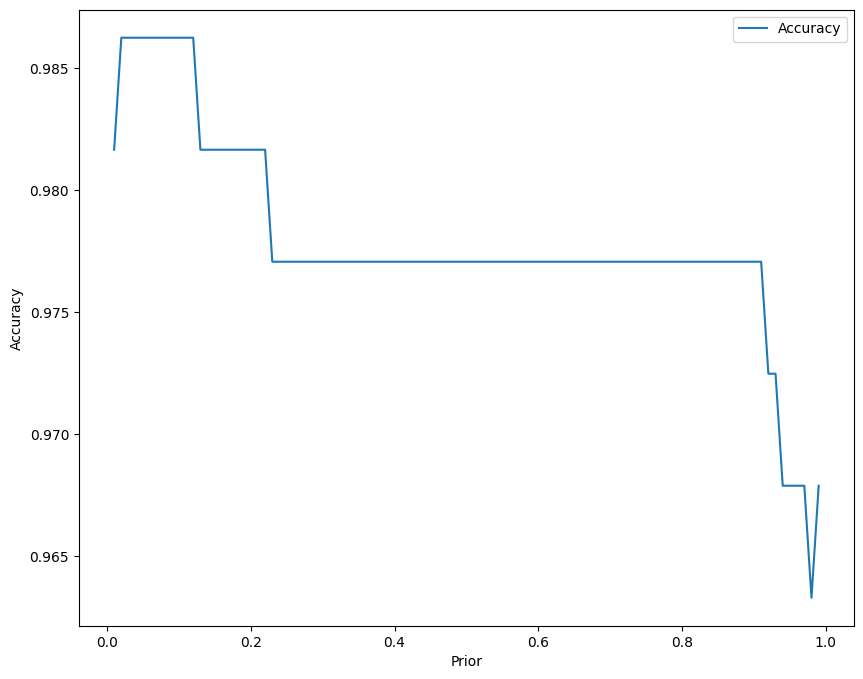

In [175]:
plt.figure(figsize=(10,8))
plt.plot(priors, accuracies, label='Accuracy')
plt.xlabel('Prior')
plt.ylabel('Accuracy')
plt.legend()
plt.show()